[#air-polution-sensor](https://github.com/Johansmm/air-polution-sensor)

 # Analyse spatio-temporelle de signaux pour détecter la dérive de capteurs mesurant la qualité de l'air
 
 Project summary (coming soon) ...

## Introduction

In [1]:
# Libraries
# Basis libraries 
import sys, getpass, os
import numpy as np
import scipy.signal
from matplotlib import rc
import matplotlib.pyplot as plt
from IPython.display import clear_output
# font = {'family':'sans-serif','sans-serif':['Helvetica'], 'size':18}
# rc('font', **font)
# rc('text', usetex=True)

# Colab libraries
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    pwd = "/content/gdrive/My Drive/S5 Project: Air polution/"    
else:
    pwd = "./"
repo_pwd = pwd + "air-polution-sensor/"

## Download repository
First, we will download the repository that contains the project [air-polution-sensor](https://github.com/Johansmm/air-polution-sensor.git). This process is optional, being necessary to activate the flag `download_repo` and enter the `user`, `email` and `password` of the repository (since the repository is initially private). Additionally you can enable the `download_db` option to download the database.

In [2]:
%cd "$pwd"
download_repo, download_db = False, False
if not os.path.isdir("air-polution-sensor") and download_repo:
    # Repository clone
    # del user_git, pwd_git, email_git
    if "user_git" not in globals(): user_git = input("User github?: ")
    try: 
        pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
    except Exception as error: 
        print('ERROR', error) 
    
    origin_git = ["https://github.com/Johansmm/air-polution-sensor.git"]
    origin_git = "\"" + origin_git[0].replace("https://","https://{}:{}@".format(user_git, pwd_git)) + "\""
    !git clone "$origin_git"
    repo_pwd = pwd + "air-polution-sensor/"

%cd $repo_pwd
if not os.path.isdir("./data") and download_db:
    if not os.path.isdir("./data"): os.mkdir("./data")
    !wget --output-document="./data/data.zip" "https://www.dropbox.com/sh/w1704rg9fd9z4pq/AABG3YCUMHTwbFhf3pKgti-Qa/PuneData_UseThis/August2019?dl=0&subfolder_nav_tracking=1"
    !unzip "./data/data.zip" -d "./data"

clear_output(wait = True)
print("[INFO]: Repository and data downloaded successfully!")

[INFO]: Repository and data downloaded successfully!


In [3]:
# Specefic libraries
%load_ext autoreload
%autoreload 2
!pip install -r requirements.txt
from libraries.global_functions import *
import ipywidgets

# Random seed
np.random.seed(0)
clear_output(wait = True)
print("[INFO]: Successfully loaded libraries!")

[INFO]: Successfully loaded libraries!


## Example of library uses

In order to explain some function of `global_functions` library, let's start with a simple example. Let's create two graphs that will represent the spatial and temporal dimension, respectively. The spatial network will be represented by a stochastic network (`create_stochastic_graph`), while the temporal notion will be provided by a path network (`create_path_graph`).

In [4]:
# Constants
SPACE_GRAPH_ORDER, SPACE_KERNEL_SCALE = 40, 20
TIME_GRAPH_ORDER, TIME_KERNEL_SCALE = 50, 20
dT = 10.0/TIME_GRAPH_ORDER # Time sample
level_noise = 0.1

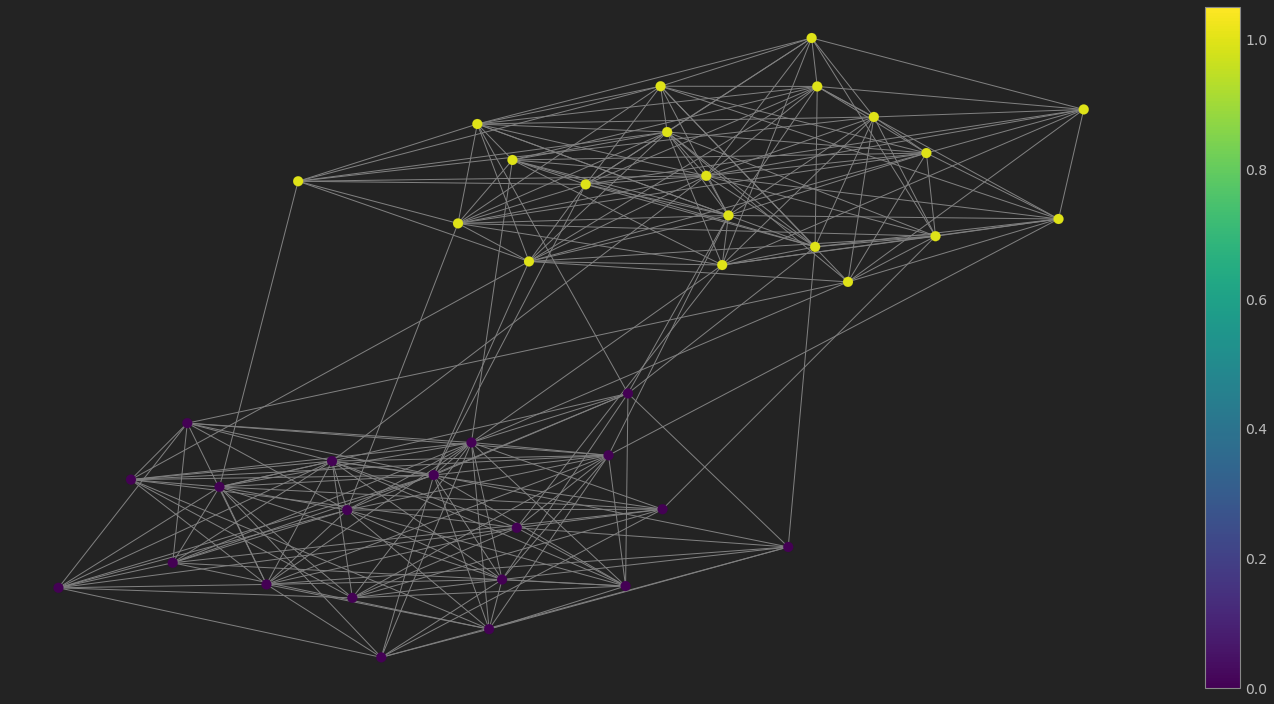

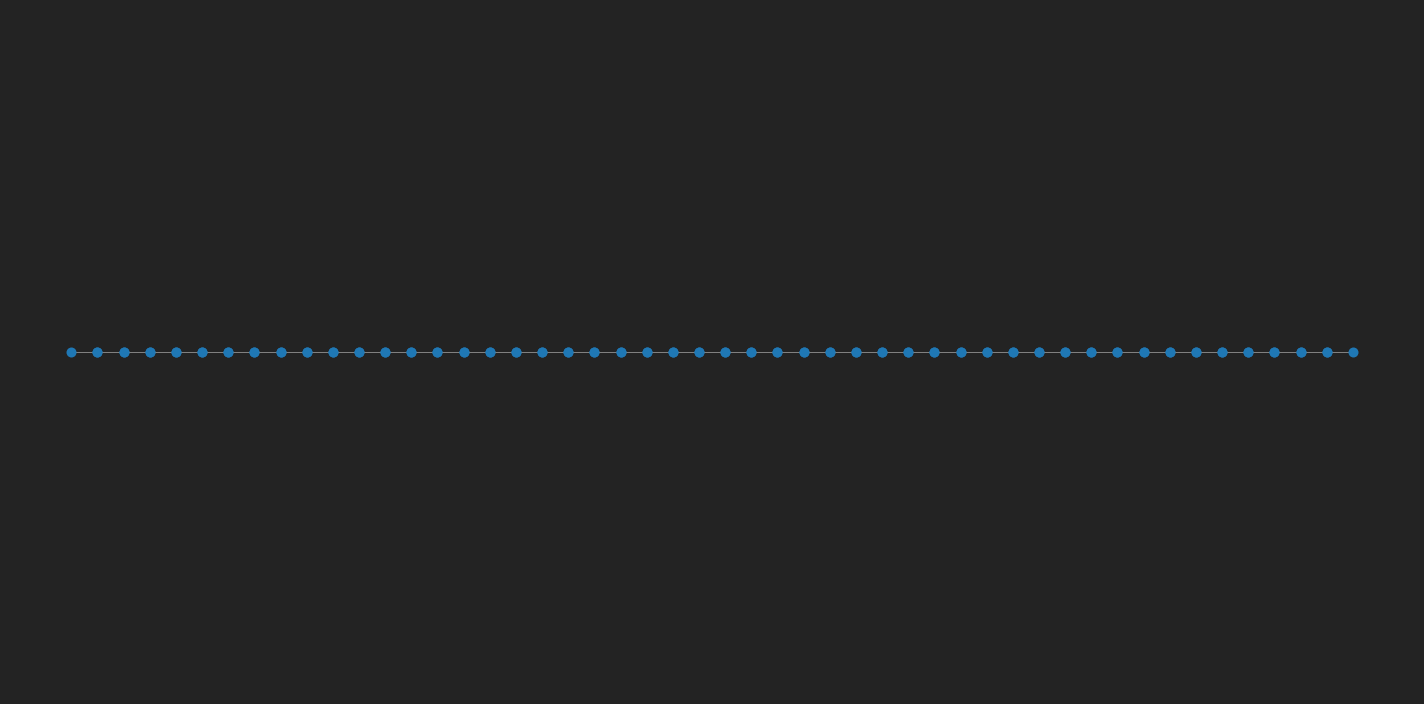

In [5]:
# Space-time graph definition
groups = np.array([0]*(SPACE_GRAPH_ORDER//2) + [1] * (SPACE_GRAPH_ORDER - SPACE_GRAPH_ORDER//2))
space_time_graph = [create_stochastic_graph(SPACE_GRAPH_ORDER, k = 2, z = groups, p=[0.6, 0.6], q = 0.05), 
         create_path_graph(TIME_GRAPH_ORDER)]

plot_graph(space_time_graph[0], groups)
plot_graph(space_time_graph[1])

Now, we will define a time series for each group of nodes present in the space network. We will then take an increasing signal for the group of nodes labeled '0', and a decreasing signal for the remaining nodes, giving us the notion that the signal "is traveling" from group 1 to group 0. We will add some white noise for general purposes.

In order to visualize and understand how the signal "travels" through the network, a time-dependent simulation was fabricated.

In [6]:
# Create a simple graph signal (sigmoid for group0 and inverse sigmoid for group1)
def signal_def(SGO = SPACE_GRAPH_ORDER, TGO = TIME_GRAPH_ORDER, dT = dT, plot_fun = False, nl = 0.01): 
    t = np.linspace(0, TIME_GRAPH_ORDER*dT, TIME_GRAPH_ORDER)
    sig = 1/(1 + np.exp(-t + 0.5*TIME_GRAPH_ORDER*dT)) # Sigmoid fun
    sig_inv = 1/(1 + np.exp(t - 0.5*TIME_GRAPH_ORDER*dT)) # Sigmoid inverse fun
    time_series = np.zeros((SGO,TGO))
    time_series[:SGO//2, :], time_series[SGO//2:, :] = sig, sig_inv
    time_series += nl*np.random.randn(*time_series.shape)
    
    if plot_fun: # If we want, we can show the both function in a new plot
        fig, ax = plt.subplots(ncols = 2, figsize=(12,6))
        t_mid = str(round(0.5*TIME_GRAPH_ORDER*dT,2))
        ax[0].plot(t, time_series[SGO//2 - 10, :]); ax[1].plot(t, time_series[SGO//2 + 10, :])
#         ax[0].set_ylabel(r"$\frac{1}{1+\exp(-x + " + t_mid + ")}$"); ax[0].set_xlabel(r"$x$")
#         ax[1].set_ylabel(r"$\frac{1}{1+\exp(x - " + t_mid + ")}$"); ax[1].set_xlabel(r"$x$")
        ax[0].set_ylabel("sig(x)"); ax[0].set_xlabel("x")
        ax[1].set_ylabel("inv sig(x)"); ax[1].set_xlabel("x")
        ax[0].grid("minor"); ax[1].grid("minor"); plt.show()
    return time_series

# Update function for the slider, with animation posibility
def update_time(instant, animation = False):
    if animation == False:
        plot_graph(space_time_graph[0], time_series[:, instant], 
                   limits = [np.min(time_series), np.max(time_series)], 
                   title = "Space-graph example at time {}".format(instant))
    else:
        for i in range(space_time_graph[1].N):
            update_time(i)
            clear_output(wait = True)

time_series = signal_def(space_time_graph[0].N, space_time_graph[1].N, dT, nl = level_noise, plot_fun = False)
ipywidgets.widgets.interact(update_time, instant = range(space_time_graph[1].N), 
                            animation = [False, True]) # Slider

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.update_time(instant, animation=False)>

To check that the desired signal was processed correctly, the signal on a particular node and its Graph Fourier Transform (GFT) can be displayed with the following code section. Remember that the signal for the same group of nodes is the same. This can be seen again in the next cell, where the same procedure is presented for the temporary graph.

In [7]:
def update_gft_space(vertex):
    plot_stem(space_time_graph[1].igft(space_time_graph[1].gft(time_series[vertex, :])),
              xticks = range(space_time_graph[1].N), ylabel="Signal", 
              title="Signal evolution at vertex " + str(vertex))
    gft_xticks = ["$\lambda^T_{" + str(x) + "}$" for x in range(space_time_graph[1].N)]
    plot_stem(space_time_graph[1].gft(time_series[vertex, :]),
              xticks = gft_xticks, ylabel="GFT", 
              title="GFT of vertex " + str(vertex))
ipywidgets.widgets.interact(update_gft_space, vertex = range(space_time_graph[0].N)) # Slider

interactive(children=(Dropdown(description='vertex', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function __main__.update_gft_space(vertex)>

In [8]:
def update_gft_time(instance):
    plot_stem(space_time_graph[0].igft(space_time_graph[0].gft(time_series[:, instance])),
              xticks = range(space_time_graph[0].N), ylabel="Signal", 
              title="Signal evolution at instance " + str(instance))
    gft_xticks = ["$\lambda^G_{" + str(x) + "}$" for x in range(space_time_graph[0].N)]
    plot_stem(space_time_graph[0].gft(time_series[:, instance]),
              xticks = gft_xticks, ylabel="GFT", 
              title="GFT in instance " + str(instance))
ipywidgets.widgets.interact(update_gft_time, instance = range(space_time_graph[1].N)) # Slider

interactive(children=(Dropdown(description='instance', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

<function __main__.update_gft_time(instance)>

Having correctly defined the signal to use, let's make a joint analysis of the space-time graph. 

In [9]:
kernels = create_joint_heat_kernel(space_time_graph, [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE])
joint_spectogram = compute_joint_graph_spectrogram(space_time_graph, time_series, kernels)

To have a more detailed understanding, we will first analyze the graphs separately. The following function allows to display the spectrogram of each network by selecting a specific time (for the spatial graph) or a specific vertex (for the temporal graph), depending on the case.

In [10]:
# Update function for the slider
def update_disj_gft(instant, vertex) :
    # Plot
    spectrogram = compute_graph_spectrogram(space_time_graph[0], time_series[:, instant], kernels[0])
    plot_matrix(spectrogram,
                cols_title="Vertex",
                cols_labels=range(space_time_graph[0].N),
                rows_title="Eigenvalue index",
                rows_labels=["$\lambda^G_{" + str(x) + "}$" for x in range(space_time_graph[0].N)],
                title="Spatial-graph spectrogram of all values observed at time " + str(instant),
                colorbar=True, limits = [0.0, 0.5]) # Values must be fixed
    spectrogram = compute_graph_spectrogram(space_time_graph[1], time_series[vertex, :], kernels[1])
    plot_matrix(spectrogram,
                cols_title="Instant",
                cols_labels=range(space_time_graph[1].N),
                rows_title="Eigenvalue index",
                rows_labels=["$\lambda^T_{" + str(x) + "}$" for x in range(space_time_graph[1].N)],
                title="Time-graph spectrogram of all values observed at vertex " + str(vertex),
                colorbar=True, limits = [np.min(spectrogram), np.max(spectrogram)])

# Slider
ipywidgets.widgets.interact(update_disj_gft, instant=range(space_time_graph[1].N), vertex=range(space_time_graph[0].N))

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.update_disj_gft(instant, vertex)>

* **Spatial-graph:** Let's remember that all the vertices in a group have the same signal, so, in a specific instant of time, the signal of each node is "constant". This is represented in the graphical-spatial spectrogram, where the only eigenvalues with considerable magnitudes are those of low order, which represent the low frequencies. As time passes, we see how the magnitudes of the nodes in group 0 begin to decrease, while those in group 1 begin to increase. However, this only happens at low frequencies.

* **Time-graph:** Focusing on the signal from only one particular node, we know that changes in sigmoidal and inverse sigmoidal signals are smooth, so your spectrogram will have non-null values in low order eigenvalues. Unlike the spatial spectogram, the presence of eigenvalues with magnitudes different from zero is evident, since the signal $s(v_i, t)$ for the vertex $v_i$ changes with time, unlike its counterpart, whose signal $s(v, t_j)$ is "constant" (without considering the introduced noise) at time $t_j$ for a group of vertices.  Finally, it is appreciated that, for the nodes of group0, the magnitudes of the spectogram increase through time, unlike the nodes of group0, whose behavior is inverse. 

Now we will enter to observe the properties of the space-time joint spectrogram. This is possible thanks to the following function. Since the joint spectrogram is in principle a two-dimensional array for each possible combination in space and time, we have as a result an array in $\mathbb{R}^4$, being useful to indicate a specific vertex and instant, looking for interpretability.

In [11]:
# Update function for the slider
def update_jft(instant, vertex) :
    # Plot
    plot_matrix(joint_spectogram[:,:, vertex, instant],
                cols_title="Eigenvalue Time-graph",
                cols_labels=["$\lambda^T_{" + str(x) + "}$" for x in range(space_time_graph[1].N)],
                rows_title="Eigenvalue Vertex-graph",
                rows_labels=["$\lambda^G_{" + str(x) + "}$" for x in range(space_time_graph[0].N)],
                title="Graph spectrogram of all values observed at time " + str(instant) + " and vertex " + str(vertex),
                colorbar=True, limits = [np.min(joint_spectogram), np.max(joint_spectogram)])

# Slider
ipywidgets.widgets.interact(update_jft, instant=range(space_time_graph[1].N), vertex=range(space_time_graph[0].N))

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.update_jft(instant, vertex)>

Taking into account that the joint spectrogram estimates different spectrograms, each of them centered on the combination ($v_i$, $t_j$), the analysis of the results should be done for each possible combination, arriving at the following statements:

1.  As explained above, the process occurs at "low frequencies" for any possible event, both in space and time, which directly affects the joint spectrogram, being only possible to see non-zero magnitudes in the upper left region (low orders of eigenvalues of space and time).
2.  The signal $s(v_i,t)$ has more frequency components compared to the signal $s(v,t_i)$, being possible to observe in the spectrogram for any combination. The reason is explained above.
3.  The magnitudes of the spectrogram for the combinations in the first instants of time and $v_i \in$ group0 or final instants of time and $v_i \in$ group1 are of low value in comparison to their counterpart, respectively. This is consistent with the shape of the signal at each vertex and for each instant of time.

## ***Anexos: GitHub-Colab connection***
Here, some commands to upload/save the github respository

In [12]:
''' Function definitions'''
# Git pull
def git_pull(repo_pwd, show_current_branch = False, make_commit = False): # Only for colab space work
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        # !git config --list
        if show_current_branch: 
            !git branch 
        if make_commit: 
            !git commit -am "Updating in colab"
        !git pull
        !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

# Git push
def git_push(repo_pwd): # Only for colab space work
    import sys
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        from google.colab import drive
        import getpass
        drive.mount('/content/gdrive')

        %cd "$repo_pwd"
        if "user" not in globals(): user_git = input("User github?: ")
        if "email" not in globals(): email_git = input("Email github?: ")

        # Password login
        try: 
            pwd_git = getpass.getpass(prompt='{} github password: '.format(user_git)) 
        except Exception as error: 
            print('ERROR', error) 

        # Upload from every where
        origin_git = !git config --get remote.origin.url
        origin_git = origin_git[0].replace("https://","https://{}:{}@".format(user_git,pwd_git))

        !git config --global user.email $email_git
        !git config --global user.name $user_git
        !git status

        x = " "
        while x.lower() != "y" and x.lower() != "n": x = input("Continue?...[y/n]: ")

        if x.lower() == "y":
            com_message = input("Enter the commit message: ")
            !git add .
            !git commit -am $com_message
            !git push $origin
            !git status
    else:
        print("[INFO] You are not in collaboration, nothing has been done.")

In order to execute the functions, please unlock the respective function

In [13]:
# git_pull(repo_pwd, show_current_branch = False, make_commit = False)
# git_push(repo_pwd)